In [1]:
import pprint
import rasterio
from rasterio import features
import rasterio.warp
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR

In [2]:
# Base values
channel_descriptions = ['M11', 'I2', 'I1', 'NDVI_last', 'EVI2_last', 'total precipitation', 'wind speed', 'wind direction', 'minimum temperature', 'maximum temperature', 'energy release component', 'specific humidity', 'slope', 'aspect', 'elevation', 'pdsi', 'LC_Type1', 'total_precipitation_surface_last', 'forecast wind speed', 'forecast wind direction', 'forecast temperature', 'forecast specific humidity', 'active fire']

min_values = [np.float32(-100.0),
 np.float32(-100.0),
 np.float32(-100.0),
 np.float32(-9966.0),
 np.float32(-4519.0),
 np.float32(0.0),
 np.float32(0.4),
 np.float32(0.0),
 np.float32(242.0),
 np.float32(257.5),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(-0.0),
 np.float32(-84.0),
 np.float32(-6.72),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(-89.999214),
 np.float32(-13.984883),
 np.float32(0.0),
 np.float32(0.0)]

max_values = [np.float32(15985.0),
 np.float32(15985.0),
 np.float32(15997.0),
 np.float32(9993.0),
 np.float32(9997.0),
 np.float32(122.0),
 np.float32(16.2),
 np.float32(360.0),
 np.float32(311.8),
 np.float32(325.4),
 np.float32(122.0),
 np.float32(0.01888),
 np.float32(67.07325),
 np.float32(359.89072),
 np.float32(4344.0),
 np.float32(8.28),
 np.float32(17.0),
 np.float32(204.1875),
 np.float32(14.295916),
 np.float32(89.98897),
 np.float32(39.505894),
 np.float32(0.014013266),
 np.float32(2218.0)]

In [3]:
fire_folders = []
look_back = 5   # 5 days sequence
all_frames = []
data_limit, loop_counter, loop_start = 5, 0, 0
channel_descriptions = None
base_path = "./data"

target_shape_x, target_shape_y = 330, 257

print('Loading...')

for fire_folder in os.listdir(base_path):
    loop_counter += 1
    if loop_counter - loop_start > data_limit:
        break
    if loop_counter < loop_start:
        continue
    print('Progress: {0}/{1} ({2})'.format(loop_counter - loop_start, data_limit, loop_counter))
    fire_folders.append(fire_folder)
    for image_name in os.listdir(base_path + f"/{fire_folder}"):
        file_path = base_path + f"/{fire_folder}/{image_name}"
        
        with rasterio.open(file_path, 'r') as geotiff:
            src = geotiff.read()
            channel_descriptions = geotiff.descriptions
            zoom_factor = (1, target_shape_x / src.shape[1], target_shape_y / src.shape[2])
            resized_src = zoom(src, zoom_factor, order=1)
            resized_src = np.nan_to_num(resized_src, copy=False)
            all_frames.append(resized_src)
            
            if fire_folder == 'fire_24332939' and False:
                print(f"shape: {geotiff.shape}")
                last_index = len(geotiff.indexes) - 1
                last_image = geotiff.read(geotiff.indexes[last_index])
                plt.figure()
                plt.title(geotiff.descriptions[last_index])
                plt.imshow(last_image)

print(f'Loading done! Count = {len(all_frames)} | Shape = {all_frames[0].shape}')

data_frames = np.stack(all_frames)
print(data_frames.shape)

Loading...
Progress: 1/5 (1)
Progress: 2/5 (2)
Progress: 3/5 (3)
Progress: 4/5 (4)
Progress: 5/5 (5)
Loading done! Count = 117 | Shape = (23, 330, 257)
(117, 23, 330, 257)


C:\Users\neelr\AppData\Local\Temp\ipykernel_6608\2108463047.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


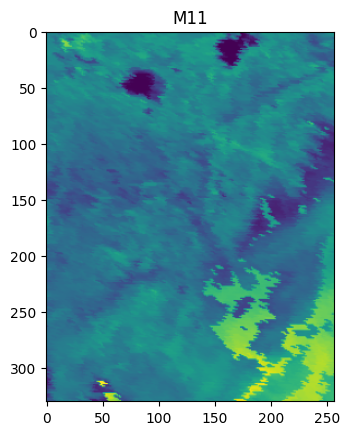

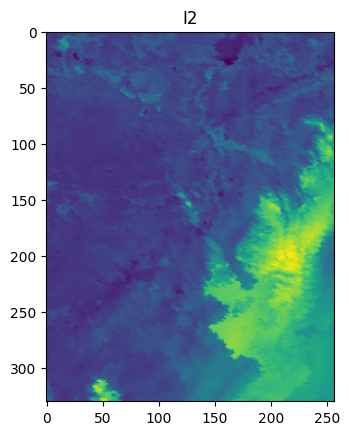

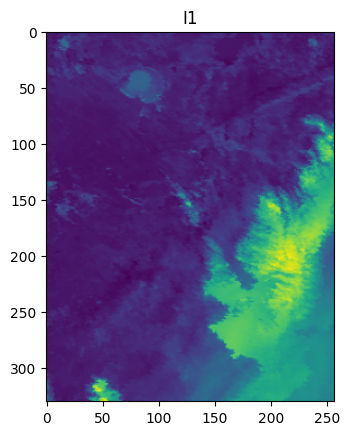

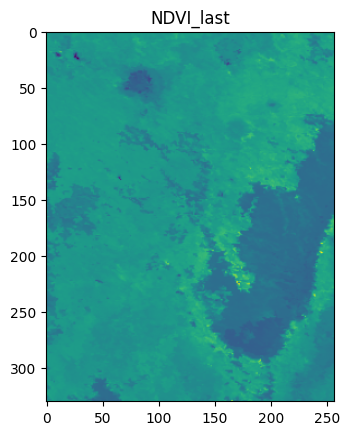

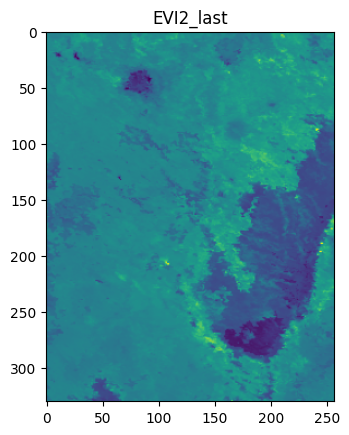

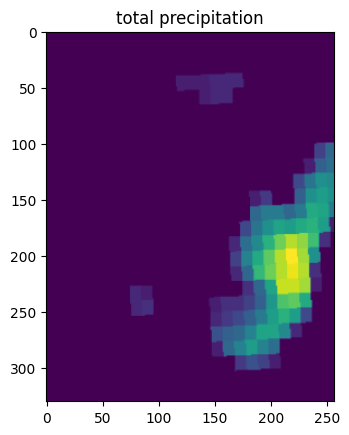

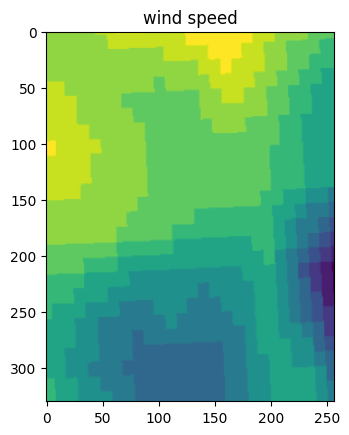

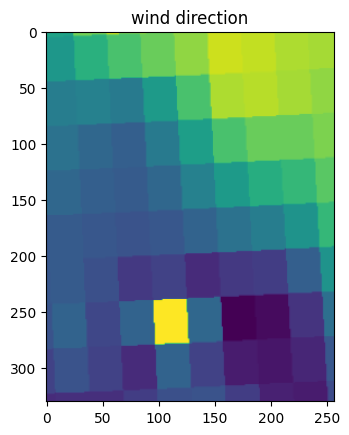

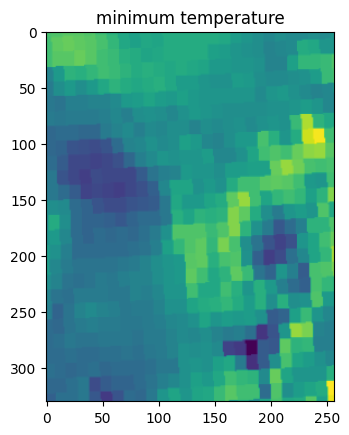

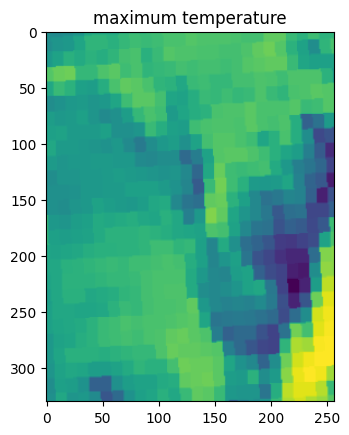

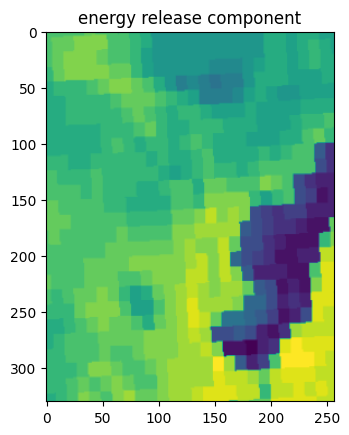

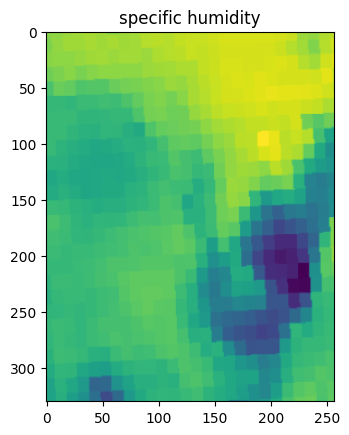

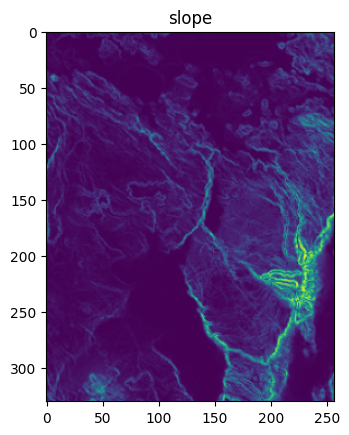

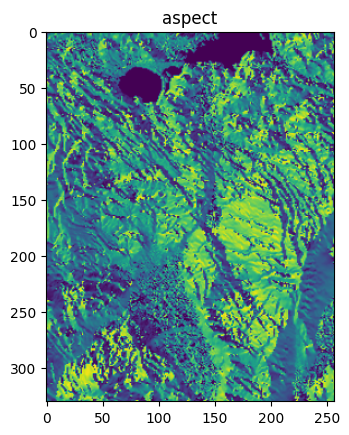

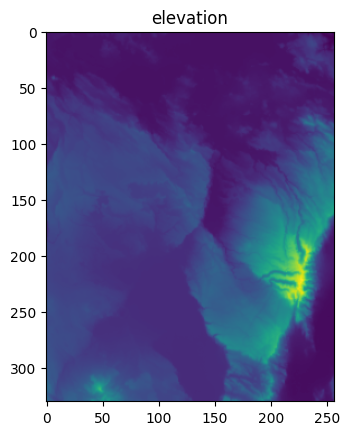

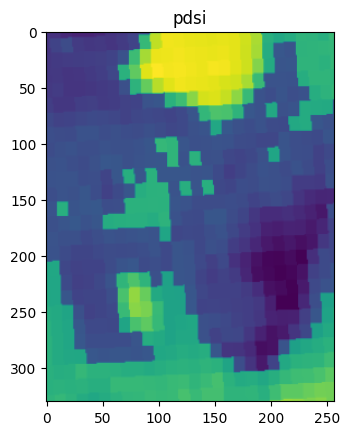

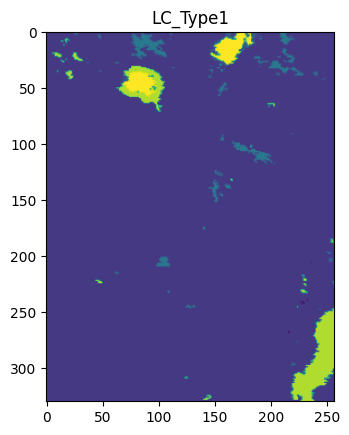

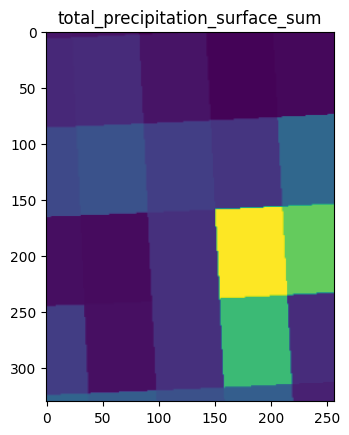

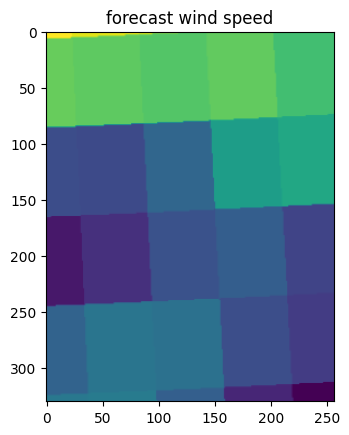

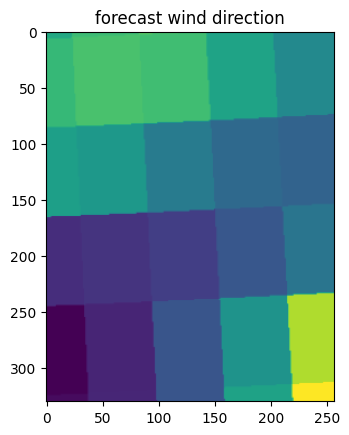

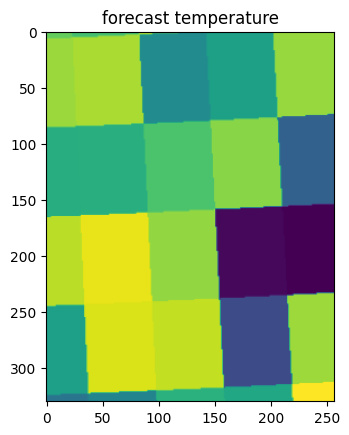

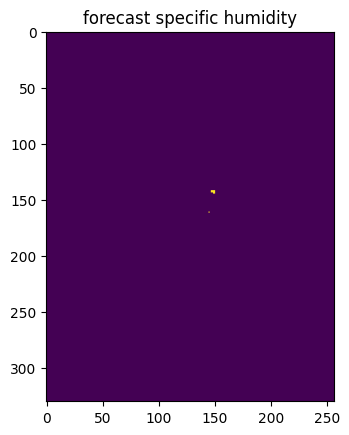

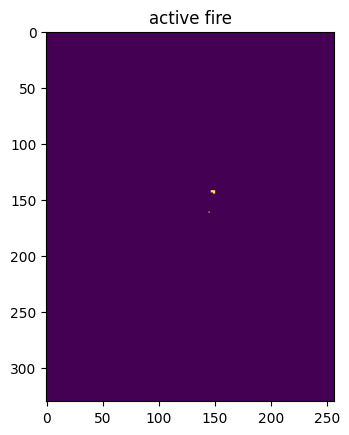

In [4]:
for i, desc in enumerate(channel_descriptions):
    plt.figure()
    sample_frame = data_frames[10, i]
    plt.title(channel_descriptions[i])
    plt.imshow(sample_frame)

#print(np.nanmin(sample_frame), np.nanmax(sample_frame))
#print(np.min(sample_frame), np.max(sample_frame))